In [96]:
import salem as sa
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproj import Proj
import numpy as np

In [2]:
data_base_folder = Path('/home/ben/data/GAR/')
project = 'rc_trop_s'

In [3]:
color_map = LinearSegmentedColormap.from_list(
    "mycmap",
    ["white", "steelblue", "c", "khaki", "orange", "orangered", "r", "darkred"],
)

def plot_map(ax, ds, model, cmap, scalebar=False):
    smap = ds.salem.get_map(data=model, cmap=cmap, vmin=0, vmax=1020)
    x, y = smap.grid.transform(lons, lats)
    smap.set_shapefile(countries=False)
    smap.set_lonlat_contours(xinterval=1)
    if scalebar:
        smap.set_scale_bar(location=(0.85, 0.08))
    smap.visualize(addcbar=False)
    return smap

In [4]:
grid = sa.mercator_grid(center_ll=(-90, 0), extent=(100000, 100000))
grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-90 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (600, 600)
  (dx, dy): (166.66666666666666, 166.66666666666666)
  (x0, y0): (-50000.0, -50000.0)

In [84]:
def open_dataset(file, pyproj_srs='+proj=merc +lat_0=2 +lon_0=-89.5 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'):
    data_base_folder = Path('/home/ben/data/GAR/')
    ds = xr.open_dataset(
        data_base_folder/file,
        decode_cf=False
    )
    split = file.split('/')[-1].split('_')
    var = split[-2]
    if var == 'lu':
        var = split[-2] + '_' + split[-1].split('.')[0]
    ds[var].attrs['pyproj_srs'] = pyproj_srs
    return ds

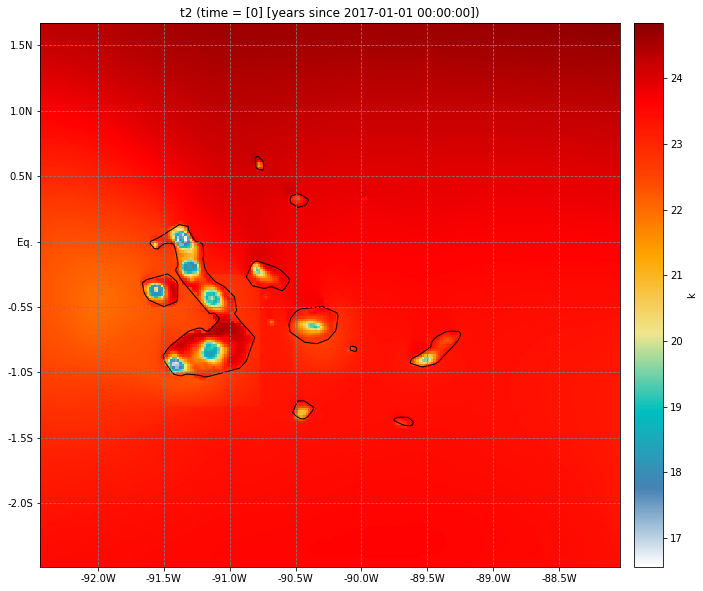

In [6]:
ds = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_t2_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.24 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ds.t2.data = ds.t2.data - 273.15
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('t2')
ds.t2.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

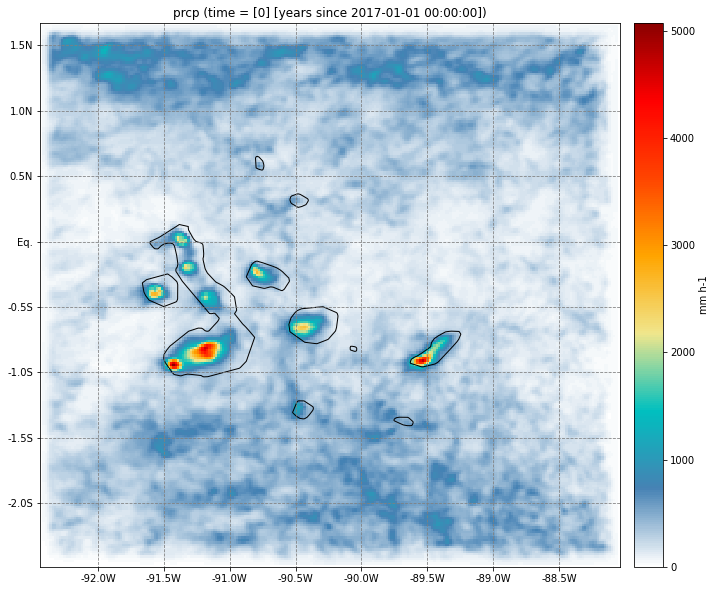

In [7]:
ds = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.24 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ds.ws.data = ds.ws.data * 24 * 365
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('ws')
ds.ws.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

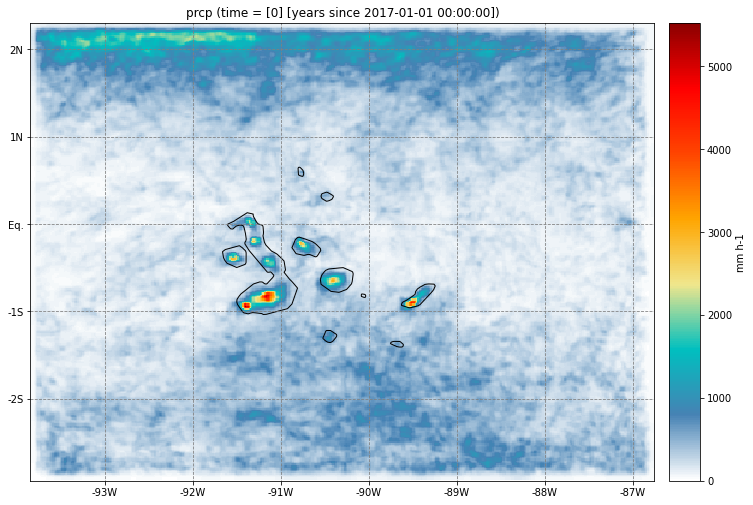

In [8]:
ds = open_dataset(
    'rc_trop/products/d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ds.ws.data = ds.ws.data * 24 * 365
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('ws')
ds.ws.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

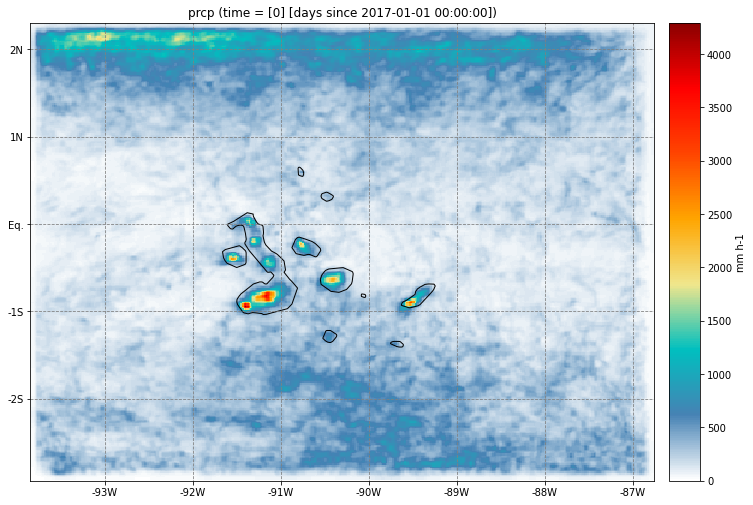

In [9]:
ds = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ds.ws.data = ds.ws.data * 24 * 365
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('ws')
ds.ws.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

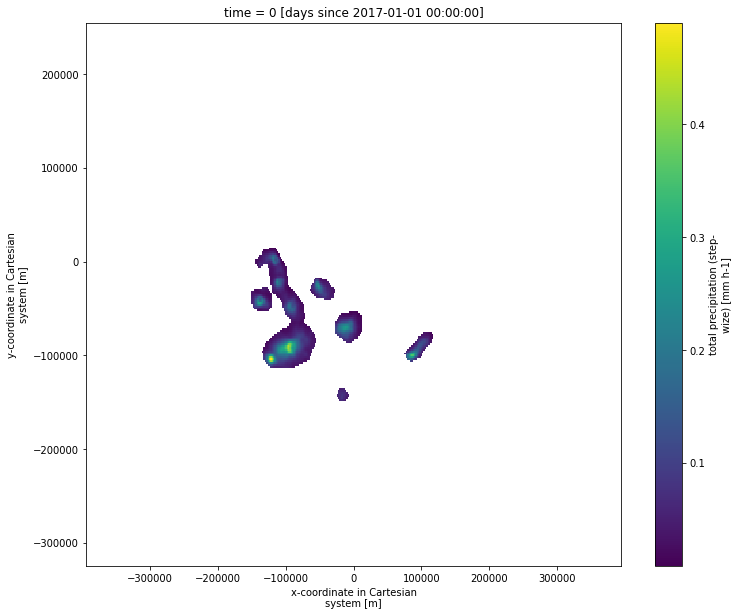

In [66]:
ds = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.plot(ax=ax)

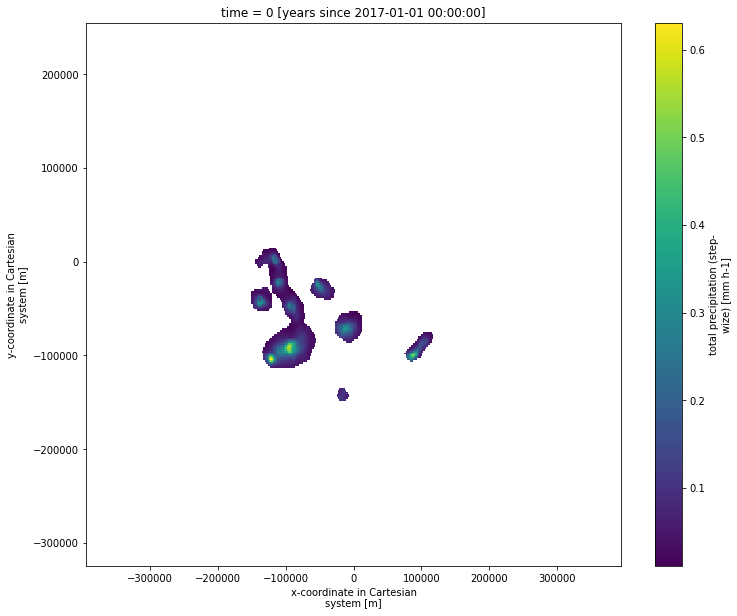

In [67]:
ds = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.plot(ax=ax)

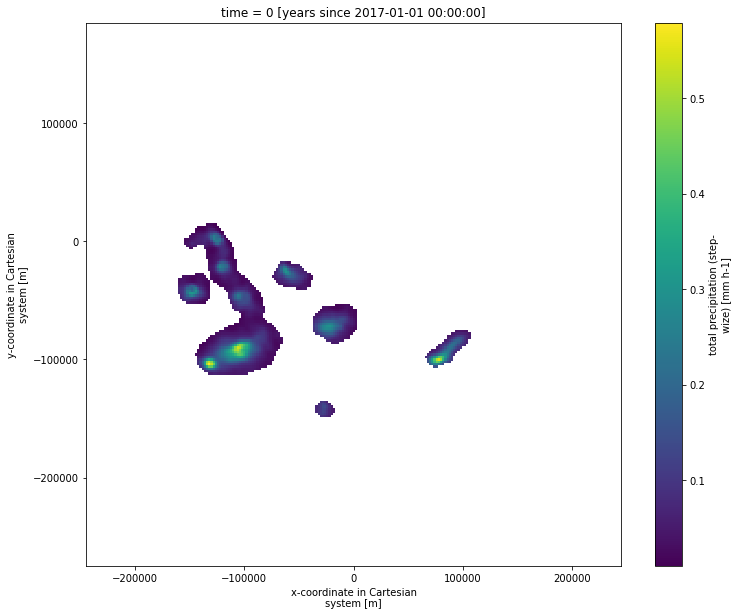

In [69]:
ds = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.21 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.plot(ax=ax)

In [72]:
l_ws = open_dataset(
    'rc_trop_l/products/d10km_d02/d/2d/rc_test_large_tropical_d10km_d02_d_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

m_ws = open_dataset(
    'rc_trop/products/d10km_d02/d/2d/rc_trop_d10km_d02_d_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

s_ws = open_dataset(
    'rc_trop_s/products/d02/d/2d/rc_trop_s_d10km_d02_d_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)


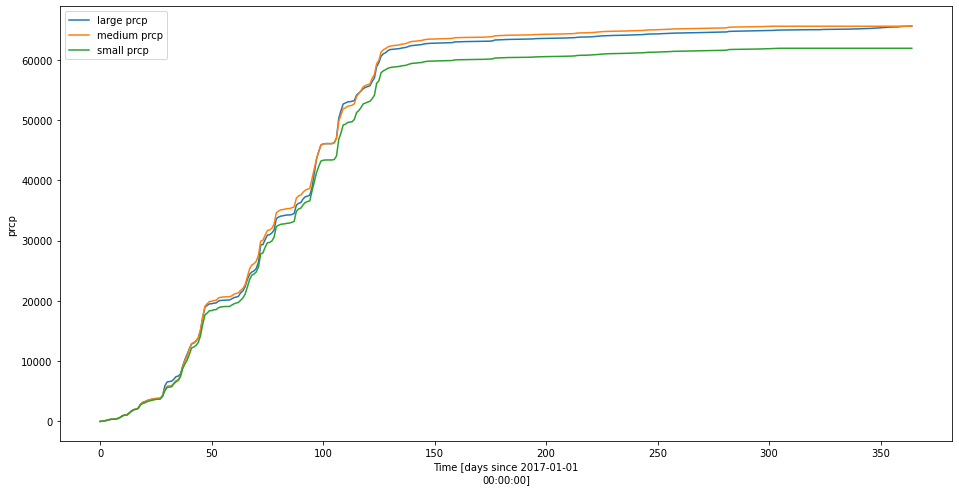

In [74]:
fig, ax = plt.subplots(figsize=(16,8))
mask_all_touched = l_ws.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="large ws")
# l_ws.ws.sum(axis=(1,2)).cumsum().plot(ax=ax, label="large ws")
mask_all_touched = m_ws.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="medium ws")
# m_ws.ws.sum(axis=(1,2)).cumsum().plot(ax=ax, label="medium ws")
mask_all_touched = s_ws.ws.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.sum(axis=(1,2)).cumsum().plot(ax=ax, label="small ws")
# s_ws.ws.sum(axis=(1,2)).cumsum().plot(ax=ax, label="small ws")
ax.legend()
plt.savefig("domain_sizes_ws_land.png")
plt.show()

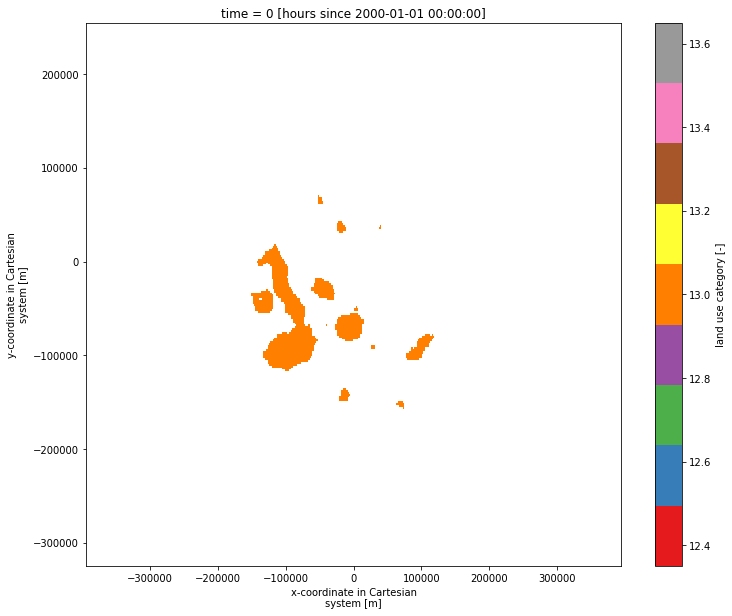

In [101]:
# plot land cover static data
lu_index = open_dataset(
    'rc_trop_l/products/d10km_d02/static/rc_test_large_tropical_d10km_d02_static_lu_index.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
lu_index.lu_index.data[lu_index.lu_index.data == 16] = np.nan

lu_index.lu_index.plot(cmap='Set1', figsize=(12,10))
plt.savefig('lu_index.png')

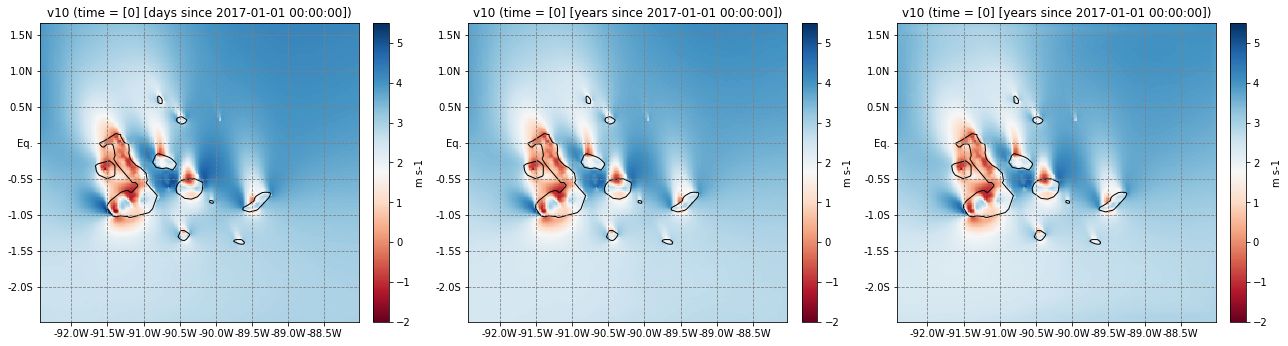

In [190]:
v10_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = v10_m.v10.salem.subset(grid=v10_s.v10.salem.grid)
v10_l = v10_l.v10.salem.subset(grid=v10_s.v10.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
v10_s.v10.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-2, vmax=5.5)
v10_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2, vmax=5.5)
v10_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2, vmax=5.5)
plt.tight_layout()
plt.savefig('v10_domains.png')
plt.show()

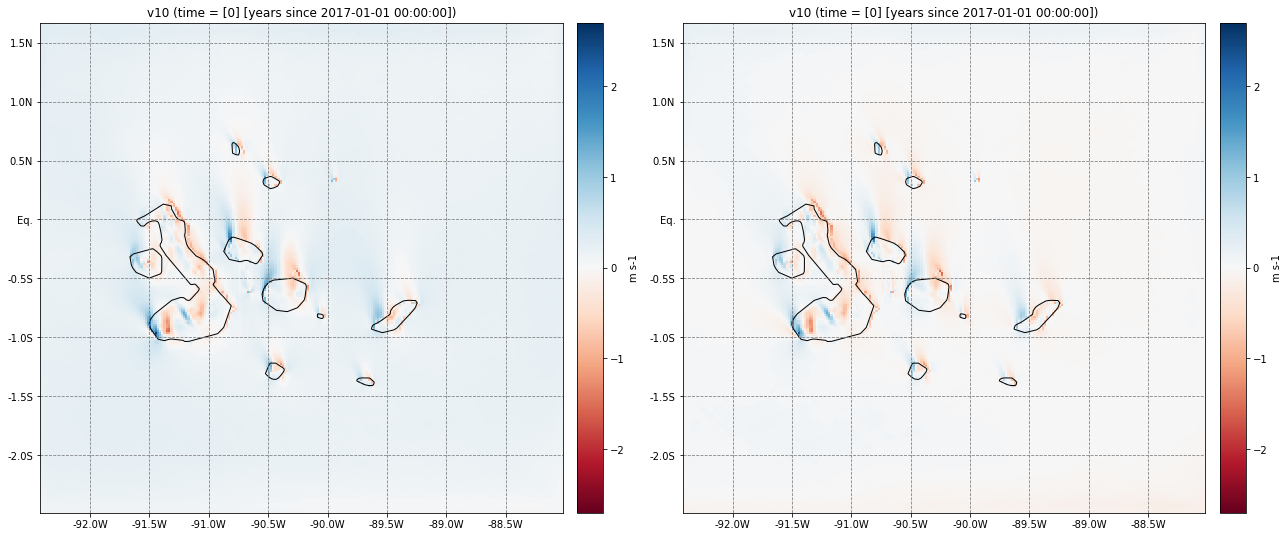

In [194]:
v10_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_l_s.v10.data = (v10_l.data - v10_s.v10.data)
v10_m_s.v10.data = (v10_m.data - v10_s.v10.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
v10_l_s.v10.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
v10_m_s.v10.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('v10_compare.png')
plt.show()

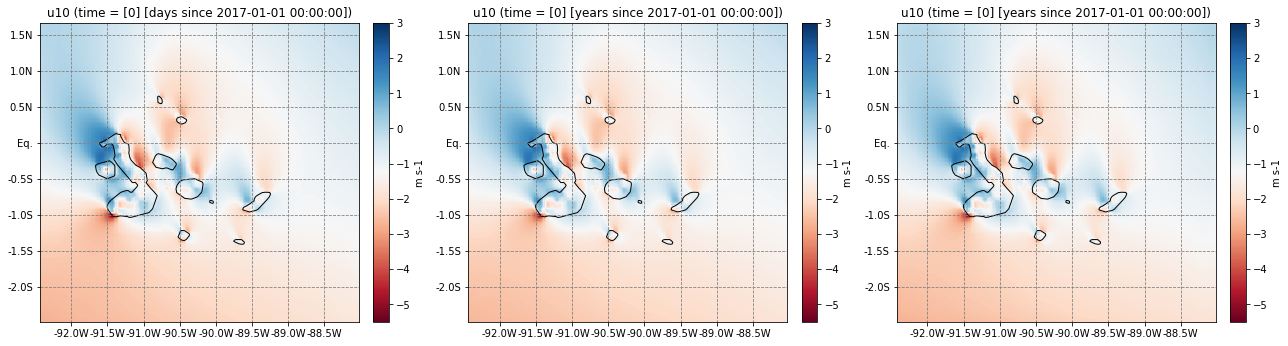

In [201]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-5.5, vmax=3, )
ws_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-5.5, vmax=3)
ws_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-5.5, vmax=3)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

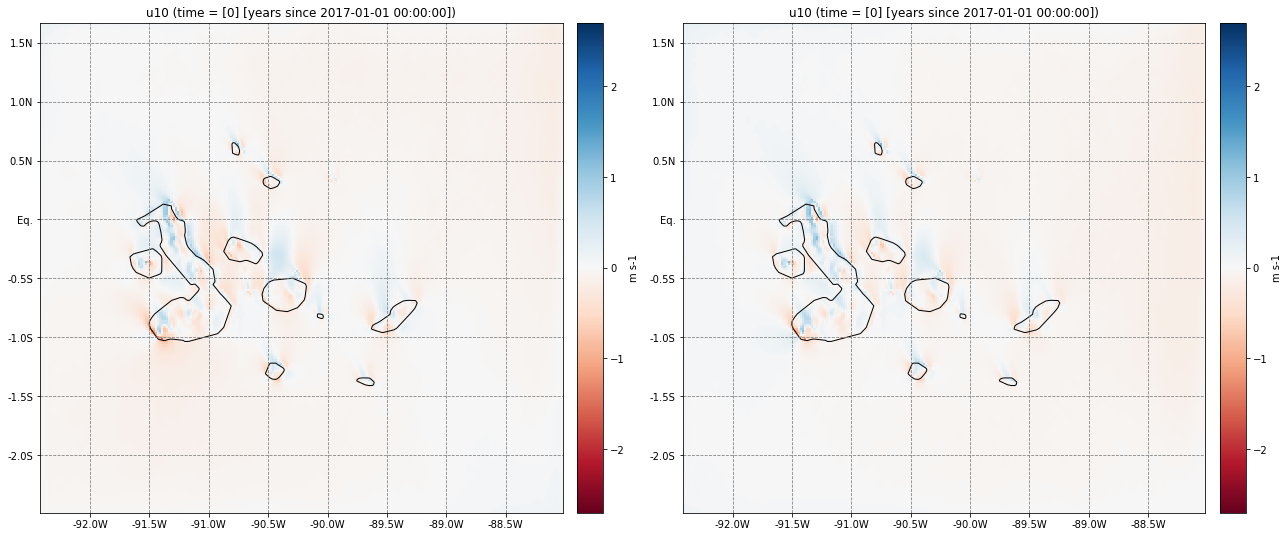

In [203]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

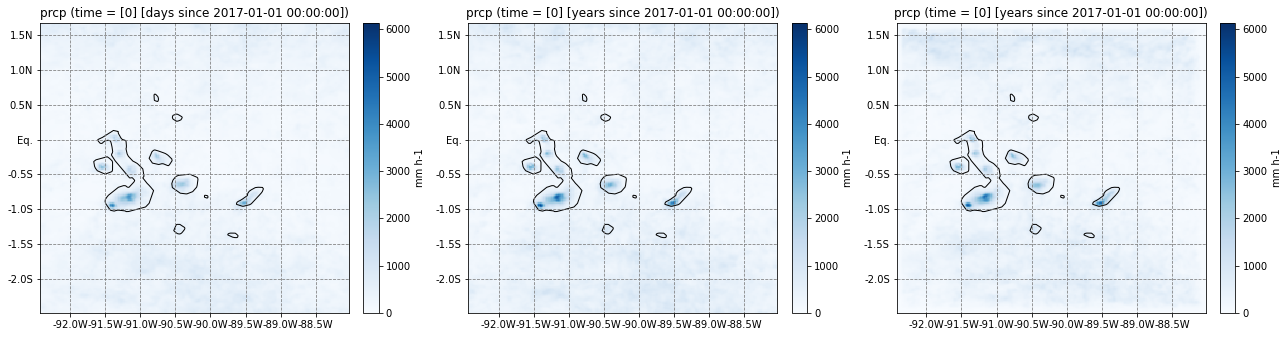

In [226]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l.ws.data = ws_l.ws.data * 24 * 365
ws_m.ws.data = ws_m.ws.data * 24 * 365
ws_s.ws.data = ws_s.ws.data * 24 * 365
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365, )
ws_m.salem.quick_map(ax=ax2, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
ws_l.salem.quick_map(ax=ax1, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

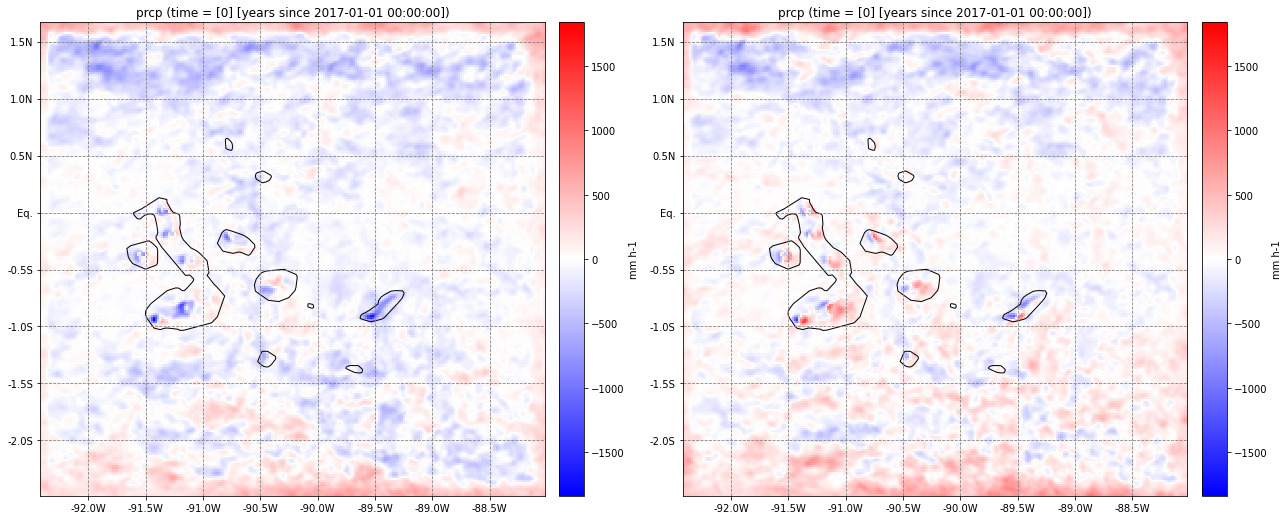

In [229]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

In [235]:
ws_l.sel(pressure=500)

<xarray.DataArray 'ws' (time: 1, south_north: 230, west_east: 245)>
array([[[6.49867 , 6.499325, ..., 6.904687, 6.906721],
        [6.501864, 6.50249 , ..., 6.908195, 6.911171],
        ...,
        [6.902314, 6.90386 , ..., 7.376873, 7.378186],
        [6.902701, 6.904034, ..., 7.375025, 7.37688 ]]], dtype=float32)
Coordinates:
  * time         (time) int32 0
  * west_east    (west_east) float32 -2.36e+05 -2.34e+05 ... 2.5e+05 2.52e+05
  * south_north  (south_north) float32 -2.74e+05 -2.72e+05 ... 1.82e+05 1.84e+05
    pressure     float32 500.0
Attributes:
    long_name:   horizontal wind speed on mass grid points
    units:       m s-1
    agg_method:  mean
    pyproj_srs:  +proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=...

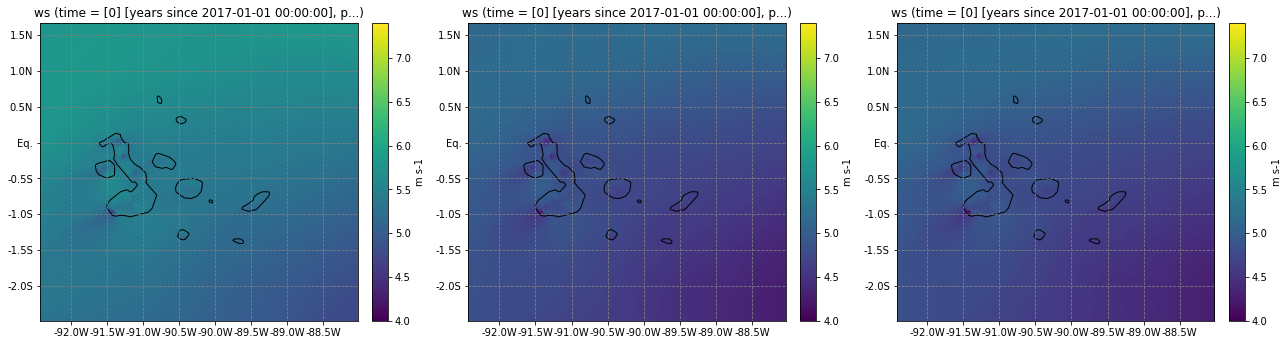

In [254]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/3d_press/rc_trop_l_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/3d_press/rc_trop_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l = ws_l.sel(pressure=800)
ws_m = ws_m.sel(pressure=800)
ws_s = ws_s.sel(pressure=800)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='viridis', vmin = 4, vmax = 7.4)
ws_m.salem.quick_map(ax=ax2, cmap='viridis', vmin = 4, vmax = 7.4)
ws_l.salem.quick_map(ax=ax1, cmap='viridis', vmin = 4, vmax = 7.4)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

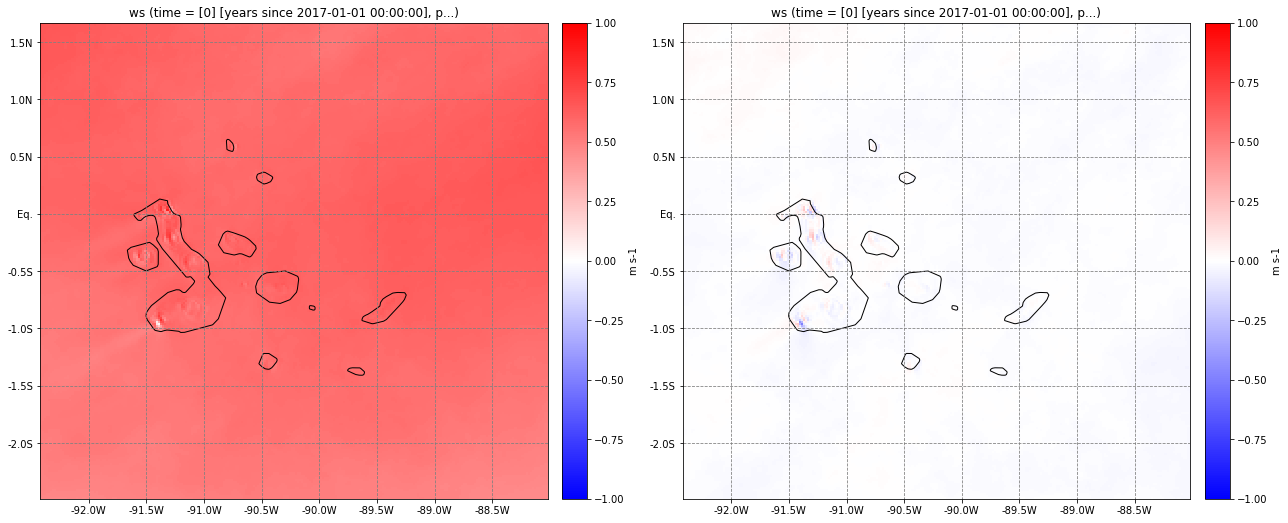

In [255]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

ws_l_s = ws_l_s.sel(pressure=800)
ws_m_s = ws_m_s.sel(pressure=800)

ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-1, vmax=1)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()